# R4 on Salient ImageNet

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import SalientImageNet
from models.pipeline import (train_model_with_certified_input_grad, train_model_with_pgd_robust_input_grad,
                             accumulate_model_with_certified_input_grad, test_model_accuracy, test_delta_input_robustness,
                             write_results_to_file, uniformize_magnitudes_schedule)
from datasets import salient_imagenet

# Get the dataloaders 

In [ ]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
DELTA_INPUT_ROBUSTNESS_PARAM = 1
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 25
test_batch_size = 25

cuda:1


In [3]:
# isic_save_path = "/vol/bitbucket/mg2720/isic/isic.pt"
# [isic_input_tensors, isic_labels] = torch.load(isic_save_path, mmap=True)
DATA_DIR = "/vol/bitbucket/mg2720/imagenet100_data"
MASKS_DIR = "/vol/bitbucket/mg2720/salient_imagenet_dataset"

# train_imgnet = salient_imagenet.ImageNetDataset(DATA_DIR, MASKS_DIR, True)
# test_imgnet = salient_imagenet.ImageNetDataset(DATA_DIR, MASKS_DIR, False)
train_imgnet = salient_imagenet.LazyImageNetDataset(DATA_DIR, MASKS_DIR, True)
test_imgnet = salient_imagenet.LazyImageNetDataset(DATA_DIR, MASKS_DIR, False)
print(len(train_imgnet), len(test_imgnet))
print(train_imgnet[0][0].shape)


6297 2099
torch.Size([3, 224, 224])


torch.Size([3, 224, 224])
3
torch.Size([3, 224, 224])
tensor(0)


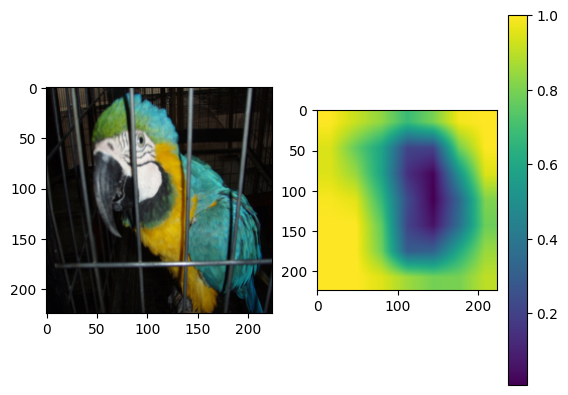

3
torch.Size([3, 224, 224])
tensor(1)


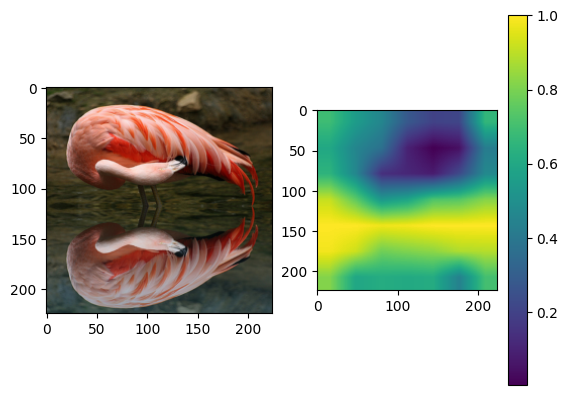

3
torch.Size([3, 224, 224])
tensor(1)


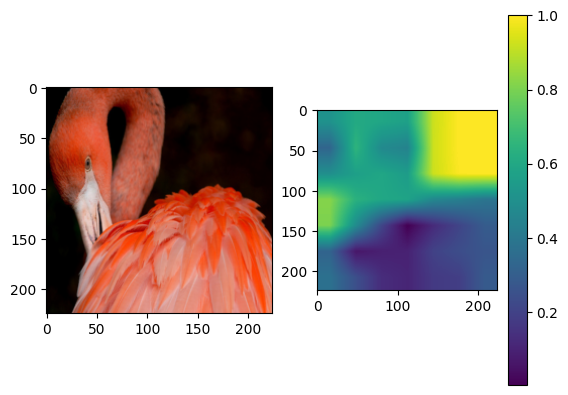

In [4]:
print((train_imgnet[0][2]).shape)
img, img_label, img_mask = None, None, None
rand_5 = torch.randint(0, len(train_imgnet), (10,))
for i in rand_5:
    img, img_label, img_mask = train_imgnet[i]
    if not torch.all(img_mask[0] == 0):
        print(img_mask.shape[0])
        print(img.shape)
        print(img_label)
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(img.float().permute(1, 2, 0).squeeze().numpy())
        im_mask = ax[1].imshow(img_mask[0].numpy())
        fig.colorbar(im_mask, ax=ax[1])
        plt.show()

In [5]:
dl_train = salient_imagenet.get_dataloader(train_imgnet, batch_size)
dl_test = salient_imagenet.get_dataloader(test_imgnet, test_batch_size)
criterion = torch.nn.CrossEntropyLoss()

## Experiments 

In [ ]:
model_root_save_dir = "saved_experiment_models/imagenet"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["std", "r3", "r4", "ibp_ex", "ibp_ex+r3"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [8]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 12, 2e-4, 3, 0.1, 0.2, -1
# k is a coefficient for the regularization term
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(3, 6)
    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
        "cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, std_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, std_method)

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 12/12 [49:17<00:00, 246.46s/it, loss=1.27, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.76
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.65
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 9.35e+04
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 12/12 [47:19<00:00, 236.65s/it, loss=1.26, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.7
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.63
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 8.94e+04
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 12/12 [38:34<00:00, 192.88s/it, loss=1.24, reg=0]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.68
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.6
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 7.76e+04


### RRR Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(3, 6)
    print(f"========== Training model with method {rrr_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
        k, device, True, k_schedule=uniformize_magnitudes_schedule, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
        "cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, rrr_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, rrr_method)


### R4 Training

In [ ]:
r4_method = "r4"
criterion = torch.nn.CrossEntropyLoss()
num_epochs, lr, restarts, epsilon, k, weight_coeff = 14, 2e-4, 3, 0.01, 0.01, -1
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(3, 6)
    print(f"========== Training model with method {r4_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method,
        k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
        "cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, r4_method)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, r4_method)

### IBP-Ex Training

In [ ]:
data_dir = "/vol/bitbucket/mg2720/imagenet100_data"
masks_dir = "/vol/bitbucket/mg2720/salient_imagenet_dataset"
train_dset = salient_imagenet.LazyImageNetDataset(data_dir, masks_dir, True)
test_dset = salient_imagenet.LazyImageNetDataset(data_dir, masks_dir, False)
dl_train = salient_imagenet.get_dataloader(train_dset, 10)
num_dynamic_per_batch = 5
dl_test = salient_imagenet.get_dataloader(test_dset, 25)
ibp_ex = "ibp_ex"
criterion = torch.nn.CrossEntropyLoss()
num_epochs, lr, restarts, epsilon, k, weight_coeff = 13, 2e-4, 3, 0.01, 0.01, 2e-4
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = SalientImageNet(3, 6)
    print(f"========== Training model with method {ibp_ex} restart {i} ==========")
    accumulate_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex,
        k, device, True, num_accs=num_dynamic_per_batch)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
        "cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex], f"model_{i}.pt"))
write_results_to_file("experiment_results/imagenet.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex)
write_results_to_file("experiment_results/imagenet_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex)

========== Training model with method ibp_ex restart 0 ==========


Epoch:   0%|          | 0/7 [00:03<?, ?it/s, loss=1.84, reg=tensor(1.7918, device='cuda:1', grad_fn=<AddBackward0>)]


OutOfMemoryError: CUDA out of memory. Tried to allocate 758.00 MiB. GPU 1 has a total capacity of 44.32 GiB of which 427.31 MiB is free. Including non-PyTorch memory, this process has 43.90 GiB memory in use. Of the allocated memory 42.77 GiB is allocated by PyTorch, and 616.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)